<a href="https://colab.research.google.com/github/LotanLevy/DOC/blob/master/jupyter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Enviroment settings**

In [ ]:
pip install tensorflow-gpu==2.3.0

     |████████████████████████████████| 320.4MB 54kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Usefull Functions**

In [ ]:
import cv2
from PIL import Image
from tensorflow.keras.applications import mobilenet_v2, vgg16

"""
resize function for mnist data
"""
def resize(x, size=96):
    x_out = []
    for i in range(len(x)):
      img = x[i]
      if img.shape[-1] == 1:
        img = cv2.cvtColor(x[i], cv2.COLOR_GRAY2RGB)
      img = cv2.resize(img,dsize=(size,size))
      x_out.append(img)
    return np.array(x_out)

"""
Mobile net network faster then vgg but acheive worse results than vgg.
Now only work for fmnist
"""
def mobilenet_v2_preprocessing(input_data):
  return input_data.astype('float32')/ 255

"""
Should work for both mnist and imagenet test
"""
def vgg_preprocessing(input_data):
  # return vgg16.preprocess_input(resize(np.copy(input_data).astype('float32'), size=size))
    return vgg16.preprocess_input(np.copy(input_data.astype('float32')))

def read_paths_file(path_to_paths_file):
  with open(path_to_paths_file, 'r') as f:
    return [line[:-1] for line in f]

def read_labels_file(path_to_labels_file):
  with open(path_to_labels_file, 'r') as f:
    return [int(line[:-1]) for line in f]

### **Dataloaders classes**

In [ ]:
import os
import numpy as np 
from PIL import Image
from sklearn.model_selection import train_test_split

"""
Data loader for fmnist data (gets the full data and their labels in the constructor)
"""
class DataIter:
  def __init__(self, data, labels, batch_size, classes_num, shuffle=False, preprocess_func=lambda x:x):
    if labels is not None:
        assert(len(data) == len(labels))
        self.labels = np.array(labels)
    else:
      self.labels = None

    self.preprocess_func = preprocess_func

    self.data = data
    self.classes_num = classes_num
    self.batch_size = batch_size
    self.indices = np.arange(len(self.data)).astype(np.int)
    self.shuffle = shuffle
    self.on_epoch_end()

  def on_epoch_end(self):
    if self.shuffle:
      np.random.shuffle(self.indices)
    self.cur_idx = 0

  def next(self):
    relevant_indices = self.indices[self.cur_idx: self.cur_idx + self.batch_size]
    self.cur_idx += self.batch_size
    images = self.data[relevant_indices]
    if self.labels is not None:
      labels = self.labels[relevant_indices]
      labels = tf.keras.utils.to_categorical(labels, num_classes=self.classes_num)
    else:
      labels = None
    return resize(self.preprocess_func(images), size), labels

  def get_all_data(self, size=None):
    if size is None:
      size = len(self.data)
    return resize(self.preprocess_func(self.data[:size]), size), None

  def __len__(self):
    return len(self.data)


"""
Data iterator that loads the data from a path only when a batch called (next and get_all_data)
"""
class DirIter:
    def __init__(self, paths, labels, batch_size, input_size, classes_num, shuffle=False, preprocess_func=lambda x:x):
      if labels is not None:
        assert(len(paths) == len(labels))
        self.labels = np.array(labels)
      else:
        self.labels = None
      self.preprocess_func = preprocess_func

      self.paths = paths
      self.classes_num = classes_num
      self.batch_size = batch_size
      self.indices = np.arange(len(self.paths)).astype(np.int)
      self.input_size = input_size
      self.shuffle = shuffle
      self.on_epoch_end()

    def __len__(self):
      return len(self.paths)

    def on_epoch_end(self):
      if self.shuffle and len(self.indices) > 0:
        np.random.shuffle(self.indices)
      self.cur_idx = 0

    def load_img(self, image_path):
        image = Image.open(image_path, 'r')
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image = image.resize(self.input_size, Image.NEAREST)
        image = np.array(image).astype(np.float32)
        return np.expand_dims(image, axis=0)

    def next(self):
        relevant_indices = self.indices[self.cur_idx: self.cur_idx + self.batch_size]
        self.cur_idx += self.batch_size
        images = []
        images = np.concatenate([self.load_img(self.paths[i]) for i in relevant_indices])
        if self.labels is not None:
          labels = self.labels[relevant_indices]
          labels = tf.keras.utils.to_categorical(labels, num_classes=self.classes_num)
        else:
          labels = None
        return self.preprocess_func(images), labels

    def get_all_data(self, size=None):
      if size is None:
        size = len(self.paths)
      relevant_paths = [self.paths[i] for i in self.indices[:size]]
      images = np.concatenate([self.load_img(path) for path in relevant_paths])
      return self.preprocess_func(images), relevant_paths

    def has_next(self):
      return self.cur_idx + self.batch_size < len(self.indices)

    def set_cls2label_map(self, map):
        self.cls2label = map

    def write_data(self, output_path, loader_name):
      with open(os.path.join(output_path, loader_name + "_paths.txt"), 'w') as f:
        for p in self.paths:
          f.write(p + "\n")
      with open(os.path.join(output_path, loader_name + "_labels.txt"), 'w') as f:
        for l in self.labels:
          f.write(str(l) + "\n")

def construct_with_files(path_file, label_file, batch_size, input_size, classes_num, shuffle=False, preprocess_func=lambda x:x):
  paths = read_paths_file(path_file)
  if label_file is not None:
    labels = read_labels_file(label_file)
  else:
    labels = None
  return DirIter(paths, labels, batch_size, input_size, classes_num, shuffle, preprocess_func)



"""
Data loader that loads data from a dir of sub dirs, each sub dir contains data of one class.
Works similarly to directory iterator, but it loads the data from a path only when a batch called (next and get_all_data)
"""
def get_iterators_by_root_dir(root_dir, batch_size, input_size, split_val, classes_num, shuffle=False, preprocess_func=lambda x:x):
    dirs = os.listdir(root_dir)
    length = len(max(dirs, key=len))

    for dir in dirs: # Handle the sort problem pads the clas num with '0'
        if len(dir) < length:
          zeros = "0" * (length - len(dir))
          new_name = zeros + dir

          os.rename(os.path.join(root_dir, dir), os.path.join(root_dir, new_name))
          print("old {}, new {}".format(dir, new_name))

    paths = []
    labels = []
    cls2label = dict()
    label_idx = 0
    for sub_dir in sorted(os.listdir(root_dir)):

        full_path = os.path.join(root_dir, sub_dir)
        if not os.path.isdir(full_path):
            continue
        cls2label[sub_dir] = label_idx
        for file in os.listdir(full_path):
            paths.append(os.path.join(full_path, file))
            labels.append(label_idx)
        label_idx += 1

    print(cls2label)


    assert len(paths) == len(labels)
    if len(cls2label) != classes_num:
        print("classes in directory doesn't match classes_num")

    if split_val > 0:
      X_train, X_test, y_train, y_test = train_test_split(paths, labels, test_size=split_val, shuffle=shuffle)
    else:
      X_train, X_test, y_train, y_test = paths, [], labels, []

    train_iter = DirIter(X_train, y_train, batch_size, input_size, classes_num, shuffle=True, preprocess_func=preprocess_func)
    val_iter = DirIter(X_test, y_test, batch_size, input_size, classes_num, shuffle=True, preprocess_func=preprocess_func)

    train_iter.set_cls2label_map(cls2label)
    val_iter.set_cls2label_map(cls2label)
    return train_iter, val_iter




###**Dataset dataloaders constructors**

In [ ]:
from keras.datasets import fashion_mnist
import numpy as np

def get_fmnist_data_loaders():
  # dataset
  (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
  x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
  x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

  #Splitting the into subsets data
  x_train_s, x_test_s, x_test_b = [], [], []
  x_ref, y_ref = [], []

  x_train_shape = x_train.shape
  #train data
  for i in range(len(x_train)):
      if y_train[i] == 7: #Sneakers is 7
          temp = x_train[i]
          x_train_s.append(temp.reshape((x_train_shape[1:])))
      else:
          temp = x_train[i]
          x_ref.append(temp.reshape((x_train_shape[1:])))
          y_ref.append(y_train[i])

  x_ref, y_ref = np.array(x_ref), np.array(y_ref)

  #test data
  for i in range(len(x_test)):
      if y_test[i] == 7: #Sneakers is 7
          temp = x_test[i,:,:,:]
          x_test_s.append(temp.reshape((x_train_shape[1:])))

      if y_test[i] == 9: #Boots is 9
          temp = x_test[i,:,:,:]
          x_test_b.append(temp.reshape((x_train_shape[1:])))

  #tdata loaders
  train_s_loader = DataIter(np.array(x_train_s), None, batchsize, classes, shuffle=True, preprocess_func=preprocessing_func)
  ref_loader = DataIter(np.array(x_ref), np.array(y_ref), batchsize, classes, shuffle=True, preprocess_func=preprocessing_func)

  test_s_loader = DataIter(np.array(x_test_s), None, batchsize, classes, preprocess_func=preprocessing_func)
  test_b_loader = DataIter(np.array(x_test_b), None, batchsize, classes, preprocess_func=preprocessing_func)
  return  train_s_loader, ref_loader, test_s_loader, test_b_loader


def get_imagenet_clatech_loaders(ref_path, tar_path, alien_path, batchsize, input_size, split_val, cls_num, shuffle=False, preprocess_func=lambda x:x):
  ref_loader, i1 = get_iterators_by_root_dir(ref_path, batchsize, input_size, 0, cls_num, shuffle=shuffle, preprocess_func=preprocess_func)
  train_s_loader, test_s_loader = get_iterators_by_root_dir(tar_path, batchsize, input_size, split_val, cls_num, shuffle=shuffle, preprocess_func=preprocess_func)
  test_alien_loader, i2 = get_iterators_by_root_dir(alien_path, batchsize, input_size, 0, cls_num, shuffle=shuffle, preprocess_func=preprocess_func)
  print(len(ref_loader), len(i1))
  print(len(train_s_loader), len(test_s_loader))
  print(len(test_alien_loader), len(i2))

  return  train_s_loader, ref_loader, test_s_loader, test_alien_loader

## **Run Settings**

In [ ]:
import tensorflow as tf
import datetime

"""
Outputs directories
"""
# main output folder
output_path = "/content/drive/My Drive/Colab Notebooks/affordances/experiments/experiment_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if not os.path.exists(output_path):
  os.makedirs(output_path)
#check points folder
ckpt_path = os.path.join(output_path, "ckpts")
if not os.path.exists(ckpt_path):
  os.makedirs(ckpt_path)
#Logs folder
epochs_log_dir = os.path.join(os.path.join(output_path, "epochs_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
batchs_log_dir = os.path.join(os.path.join(output_path, "batchs_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))


# MobileNetV2
# size = 96
# preprocessing_func = mobilenet_v2_preprocessing
# first_trained_layer_name = "block_13_expand"
# alpha = 0.5 #for MobileNetV2
# network_constractor = lambda : tf.keras.applications.MobileNetV2(include_top=True, input_shape=(size, size, 3), alpha=alpha, weights='imagenet')


# VGG16
size = 224
preprocessing_func = vgg_preprocessing
first_trained_layer_name =  "block5_conv1"
network_constractor = lambda : tf.keras.applications.VGG16(include_top=True, input_shape=(size, size, 3), weights='imagenet')
test_size = 200



lambda_ = 0.1 #for compact loss

# fmnist data
# classes = 10
# batchsize = 2
# train_s_loader, ref_loader, test_s_loader, test_b_loader = get_fmnist_data_loaders()

# # imagenet clatech data
REFERENCE_PATH = "/content/drive/My Drive/Colab Notebooks/affordances/datasets/imagenet_val_splitted"
TARGET_PATH = "/content/drive/My Drive/Colab Notebooks/affordances/datasets/stab_data"
ALIEN_PATH = "/content/drive/My Drive/Colab Notebooks/affordances/datasets/tovisualize"
classes = 1000
batchsize = 2
split_val = 0.2

train_s_loader, ref_loader, test_s_loader, test_b_loader = get_imagenet_clatech_loaders(REFERENCE_PATH, TARGET_PATH, ALIEN_PATH, batchsize, (size,size), split_val, classes, shuffle=True, preprocess_func=preprocessing_func)

path_file = (output_path, "target_test"+"_paths.txt")
label_file = (output_path, "target_test"+"_labels.txt")


train_s_loader.write_data(output_path, "target_train")
test_s_loader.write_data(output_path, "target_test")
test_b_loader.write_data(output_path, "alien_test")




{'0000000000000000': 0, '0000000000000001': 1, '0000000000000002': 2, '0000000000000003': 3, '0000000000000004': 4, '0000000000000005': 5, '0000000000000006': 6, '0000000000000007': 7, '0000000000000008': 8, '0000000000000009': 9, '0000000000000010': 10, '0000000000000011': 11, '0000000000000012': 12, '0000000000000013': 13, '0000000000000014': 14, '0000000000000015': 15, '0000000000000016': 16, '0000000000000017': 17, '0000000000000018': 18, '0000000000000019': 19, '0000000000000020': 20, '0000000000000021': 21, '0000000000000022': 22, '0000000000000023': 23, '0000000000000024': 24, '0000000000000025': 25, '0000000000000026': 26, '0000000000000027': 27, '0000000000000028': 28, '0000000000000029': 29, '0000000000000030': 30, '0000000000000031': 31, '0000000000000032': 32, '0000000000000033': 33, '0000000000000034': 34, '0000000000000035': 35, '0000000000000036': 36, '0000000000000037': 37, '0000000000000038': 38, '0000000000000039': 39, '0000000000000040': 40, '0000000000000041': 41, '

# **Train**

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

#Loss function
def compactness_loss(y_true, y_pred):
    n_dim = np.shape(y_pred)[0]  # number of features vecs
    k_dim = np.shape(y_pred)[1]  # feature vec dim
    lc = 1/(k_dim*n_dim)* n_dim**2 * K.sum((y_pred - K.mean(y_pred,axis=0))**2,axis=[1]) / ((n_dim-1)**2)
    return lc

#Learning
def train(target_dataloader, reference_dataloader, epoch_num):
    print("Model build...")

    network = network_constractor()
    #Freeze weight
    for layer in network.layers:
        if layer.name == first_trained_layer_name:
            break
        else:
            layer.trainable = False
    # Secondary network
    model_t = Model(inputs=network.input,outputs=network.layers[-2].output)
    # Reference network
    #Apply a Fully Connected Layer to R
    # prediction = Dense(classes, activation='softmax')(model_t.output) # for fmnist
    model_r = Model(inputs=model_t.input,outputs=network.layers[-1].output) # for imagenet
    
    #Compile
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    optimizer = SGD(lr=5e-5, decay=0.00005)
    model_r.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[train_accuracy])
    model_t.compile(optimizer=optimizer, loss=compactness_loss)

    # Prints run settings
    model_t.summary()
    model_r.summary()
    print("x_target is", len(target_dataloader),'samples')
    print("x_ref is",len(reference_dataloader),'samples')

    # run loggers
    epochs_writer = tf.summary.create_file_writer(logdir=epochs_log_dir)
    # batchs_writer = tf.summary.create_file_writer(logdir=batchs_log_dir)

    outputs = {"d loss": [], "c loss": [], "accuracy": []}
    loss, loss_c, epoch_accuracy = [], [], []

    print("training...")
    #Learning
    for epochnumber in range(epoch_num):
        lc, ld, accuracy = [], [], [] # epoch loaders
        for i in range(int(len(target_dataloader) / batchsize)):
            #Load data for batch size 
            batch_is_ready = False
            while not batch_is_ready:
              try:
                batch_target, _ = target_dataloader.next()
                batch_is_ready = True
              except: # some error in loading the data
                if not target_dataloader.has_next():
                    target_dataloader.on_epoch_end()
                continue

            batch_ref, batch_y = reference_dataloader.next()

            #target data
            #Get loss while learning
            lc.append(model_t.train_on_batch(batch_target, np.zeros((batchsize, 4096))))

            #reference data
            #Get loss while learning
            ref_output = model_r.train_on_batch(batch_ref, batch_y)
            ld.append(ref_output[0])
            accuracy.append(ref_output[1])
            count = (epochnumber * int(len(target_dataloader) / batchsize)) + i

            # if count % 50 == 0:
            #   with batchs_writer.as_default():
            #     tf.summary.scalar("d loss", np.mean(ld), step=count)
            #     tf.summary.scalar("c loss", np.mean(lc), step=count)
            #     tf.summary.scalar("accuracy", np.mean(accuracy), step=count)
            #   print("batch: {}: d loss {}, c loss {}, accuracy {}".format(count, np.mean(ld), np.mean(lc), np.mean(accuracy)))

        target_dataloader.on_epoch_end()
        reference_dataloader.on_epoch_end()

        outputs["d loss"].append(np.mean(ld))
        outputs["c loss"].append(np.mean(lc))
        outputs["accuracy"].append(np.mean(accuracy))
        with epochs_writer.as_default():
          for key in outputs:
            tf.summary.scalar(key, outputs[key][-1], step=epochnumber+1)
        print("epoch: {}: d loss {}, c loss {}, accuracy {}".format(epochnumber+1, outputs["d loss"][-1], outputs["c loss"][-1], outputs["accuracy"][-1] ))

        checkpoint_path = "weights_after_{}_epochs".format(epochnumber+1)
        network.save_weights(os.path.join(ckpt_path, checkpoint_path))



    #Result graph
    plt.plot(outputs["d loss"],label="Descriptive loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

    plt.plot(outputs["c loss"],label="Compact loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show() 

    plt.plot(outputs["accuracy"],label="accuracy")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()   

    return model_t



model = train(train_s_loader, ref_loader, 5)

Model build...
553467904/553467096 [==============================] - 14s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________

KeyboardInterrupt: ignored

### **Display roc curve**

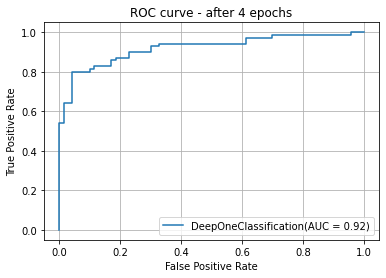

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import os
from tensorflow.keras.models import Model


classes_num = 1000
batch_size = 2
size = 224
preprocessing_func = vgg_preprocessing
network_constractor = lambda : tf.keras.applications.VGG16(include_top=True, input_shape=(size, size, 3), weights='imagenet')



output_path = "/content/drive/My Drive/Colab Notebooks/affordances/experiments/experiment_knives_only"
ckpt_path = os.path.join(output_path, "ckpts")
roc_path = os.path.join(output_path, "roc_graphs")

if not os.path.exists(roc_path):
  os.makedirs(roc_path)

EPOCH_NUM = 4
model = network_constractor()
model.load_weights(os.path.join(ckpt_path, "weights_after_{}_epochs".format(EPOCH_NUM))).expect_partial()
model = Model(inputs=model.input,outputs=model.layers[-2].output)

target_train_paths, target_train_labels = os.path.join(output_path, "target_train_paths.txt"), os.path.join(output_path, "target_train_labels.txt")
target_test_paths, target_test_labels = os.path.join(output_path, "target_test_paths.txt"), os.path.join(output_path, "target_test_labels.txt")
alien_test_paths, alien_test_labels = os.path.join(output_path, "target_alien_paths.txt"), os.path.join(output_path, "target_alien_labels.txt")

train_s_loader = construct_with_files(target_train_paths, None, batch_size, (size,size), classes_num, False, preprocessing_func)
test_s_loader = construct_with_files(target_test_paths, None, batch_size, (size,size), classes_num, False, preprocessing_func)
test_b_loader = construct_with_files(alien_test_paths, None, batch_size, (size,size), classes_num, False, preprocessing_func)


X_train_s, relevant_paths_train_s = train_s_loader.get_all_data(size=40)
X_test_s, relevant_paths_test_s = test_s_loader.get_all_data(size=70)
X_test_b, relevant_paths_test_b = test_b_loader.get_all_data(size=70)

train = model.predict(X_train_s)
test_s = model.predict(X_test_s)
test_b = model.predict(X_test_b)

train = train.reshape((len(X_train_s),-1))
test_s = test_s.reshape((len(X_test_s),-1))
test_b = test_b.reshape((len(X_test_b),-1))

test_s_losses = np.zeros(len(test_s))
for i in range(len(test_s)):
  losses = tf.keras.losses.mean_squared_error(train, tf.expand_dims(test_s[i], axis=0))
  test_s_losses[i] = np.array(tf.math.reduce_min(losses))

test_b_losses = np.zeros(len(test_b))
for i in range(len(test_b)):
  losses = tf.keras.losses.mean_squared_error(train, tf.expand_dims(test_b[i], axis=0))
  test_b_losses[i] = np.array(tf.math.reduce_min(losses))

#Abnormal score
Z1 = test_s_losses
Z2 = test_b_losses


# #Convert to 0-1
# ms = MinMaxScaler()
# train = ms.fit_transform(train)
# test_s = ms.transform(test_s)
# test_b = ms.transform(test_b)

# # fit the model
# clf = LocalOutlierFactor(n_neighbors=5)
# y_pred = clf.fit(train)

# #Abnormal score
# Z1 = -clf._decision_function(test_s)
# Z2 = -clf._decision_function(test_b)

#Drawing of ROC curve
y_true = np.zeros(len(test_s)+len(test_b))
y_true[len(test_s):] = 1 #0:Normal, 1：Abnormal

#Calculate FPR, TPR(, Threshould)
fpr, tpr, _ = metrics.roc_curve(y_true, np.hstack((Z1, Z2)))

#AUC
auc = metrics.auc(fpr, tpr)

#Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='DeepOneClassification(AUC = %.2f)'%auc)
plt.legend()
plt.title('ROC curve - after {} epochs'.format(EPOCH_NUM))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.savefig(os.path.join(roc_path, "epoch_{}.png".format(EPOCH_NUM)))
plt.show()


In [ ]:
import os
print(os.listdir("/content/drive/My Drive/Colab Notebooks/affordances/experiments"))
# os.rename("/content/drive/My Drive/Colab Notebooks/affordances/experiments/experiment_all_stab (1)", "/content/drive/My Drive/Colab Notebooks/affordances/experiments/experiment_all_stab")

['experiment_knives_only', 'experiment_all_stab']


### **Writing predictions**

In [ ]:
results_path = os.path.join(output_path, "preds")

PRED_S_RESULTS_PATH = os.path.join(output_path, "pred_s_results.txt")
PRED_B_RESULTS_PATH = os.path.join(output_path, "pred_b_results.txt")


with open(PRED_S_RESULTS_PATH, "w") as rf:
  test_s_scores = list(zip(relevant_paths_test_s, Z1))
  for item in test_s_scores:
    rf.write("{}\n".format(item))

with open(PRED_B_RESULTS_PATH, "w") as rf:
  test_b_scores = list(zip(relevant_paths_test_b, Z2))
  for item in test_b_scores:
    rf.write("{}\n".format(item))


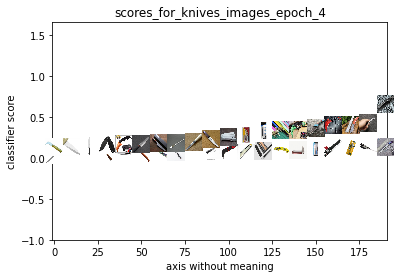

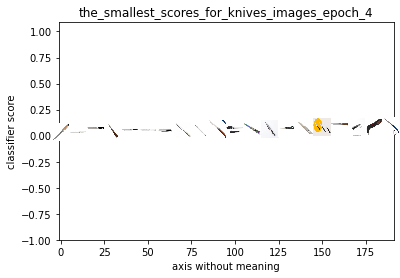

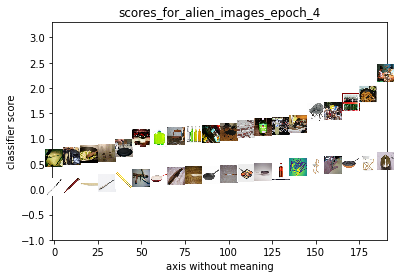

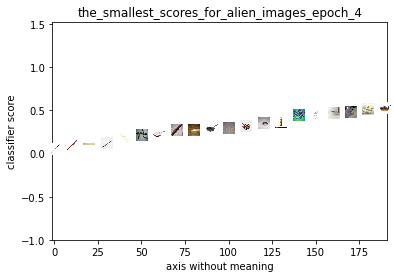

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import math
from skimage.transform import resize


def map_path_to_class(paths):
  paths2cls = dict()
  for path in paths:
    cls = path.split('/')[-2]
    paths2cls[path] = cls
  return paths2cls


def getImage(path, zoom):
  image = plt.imread(path)
  image = resize(image, (224, 224))
  return OffsetImage(image, zoom=zoom)


def create_images_graph(output_path, paths, scores, name, zoom, columns, max_objects=None):
  if max_objects is None:
    max_objects = len(scores)
  paths2cls = map_path_to_class(paths)
  indices =  np.argsort(scores)[:max_objects]
  scores = scores[indices]

  step = 10

  x = list(range(columns)) * math.ceil(len(indices)/float(columns))

  x = [step * i for i in x]
  x = x[:len(scores)]
  fig, ax = plt.subplots()
  # ax.scatter(x, scores[indices]) 
  for i in range(max_objects):
    idx = indices[i]
    ab = AnnotationBbox(getImage(paths[idx], zoom), (x[i], scores[i]), frameon=False)
    ax.scatter(x[i], scores[i]) 
    ax.add_artist(ab)
  ax.update_datalim(np.column_stack([x, scores]))
  ax.autoscale()
  ax.set_ylim(-1,max(scores)+1)
  ax.set_xlim(-1,max(x)+1)
  plt.ylabel("classifier score")
  plt.xlabel("axis without meaning")
  plt.title(name)
  plt.savefig(os.path.join(output_path, "scores visualization_of_{}.png".format(name)), dpi=500)
  plt.show()


results_output_path = os.path.join(output_path, "results_for_epoch_{}".format(EPOCH_NUM))
if not os.path.exists(results_output_path):
  os.makedirs(results_output_path)



create_images_graph(results_output_path, relevant_paths_test_s[:40], Z1[:40], "scores_for_knives_images_epoch_{}".format(EPOCH_NUM), 0.08, 20)
create_images_graph(results_output_path, relevant_paths_test_s, Z1, "the_smallest_scores_for_knives_images_epoch_{}".format(EPOCH_NUM), 0.08, 20, 20)
create_images_graph(results_output_path, relevant_paths_test_b[:40], Z2[:40], "scores_for_alien_images_epoch_{}".format(EPOCH_NUM), 0.08, 20)
create_images_graph(results_output_path, relevant_paths_test_b, Z2, "the_smallest_scores_for_alien_images_epoch_{}".format(EPOCH_NUM), 0.05, 20, 20)


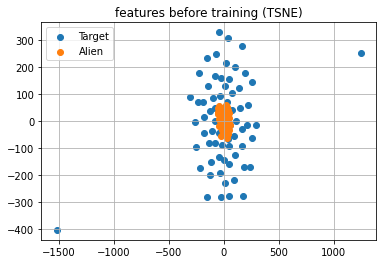

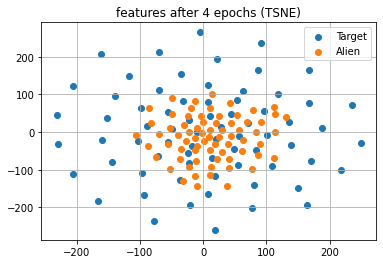

In [ ]:
from sklearn.manifold import TSNE


new_network = network_constractor()

new_network = Model(inputs=new_network.input,outputs=new_network.layers[-2].output)




# new_mobile = tf.keras.applications.MobileNetV2(include_top=True, input_shape=(size, size, 3), alpha=alpha, weights='imagenet')

untrained_test_s = new_network.predict(X_test_s)
untrained_test_b = new_network.predict(X_test_b)

untrained_test_s_embedded = TSNE(n_components=2).fit_transform(untrained_test_s)
untrained_test_b_embedded = TSNE(n_components=2).fit_transform(untrained_test_b)

plt.figure()
plt.scatter(untrained_test_s_embedded[:, 0],untrained_test_s_embedded[:,1], label="Target")
plt.scatter(untrained_test_b_embedded[:, 0],untrained_test_b_embedded[:,1], label="Alien")
plt.legend()
plt.grid(True)
plt.title("features before training (TSNE)")
plt.savefig(os.path.join(output_path, "features_before_training.png"))

plt.show()


test_s_embedded = TSNE(n_components=2).fit_transform(test_s)
test_b_embedded = TSNE(n_components=2).fit_transform(test_b)

plt.figure()
plt.scatter(test_s_embedded[:, 0],test_s_embedded[:,1], label="Target")
plt.scatter(test_b_embedded[:, 0],test_b_embedded[:,1], label="Alien")
plt.title("features after {} epochs (TSNE)".format(EPOCH_NUM))
plt.savefig(os.path.join(output_path, "features_after_{}_epochs.png".format(EPOCH_NUM)))
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

class GradCAM:
    def __init__(self, model, templates):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = Model(inputs=model.input, outputs=model.layers[-1].output)
        self.templates = templates
        self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image,eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                     self.model.output])
        # record operations for automatic differentiation

        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            inputs = tf.Variable(inputs)
            tape.watch(inputs)

            (convOutputs, predictions) = gradModel(inputs)
            (t_convOutputs, t_predictions) = gradModel(self.templates)
            train = tf.reshape(t_predictions, (len(self.templates), -1))
            test = tf.reshape(predictions, (len(image), -1))
            losses = tf.keras.losses.mean_squared_error(train, test)

            loss = tf.math.reduce_min(losses)

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap, loss

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_JET ):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import imagenet_utils
import imutils
import re


def image_name(image_path):
    regex = ".*[\\/|\\\](.*)[\\/|\\\](.*).(jpg|JPEG)"
    m = re.match(regex, image_path)
    return m.group(1) + "_" + m.group(2)


def get_gradCam_image(models_dict, image_path, output_path, templates):

    image = read_image(image_path, (size, size))
    orig = np.array(Image.open(image_path).convert('RGB'))

    all_outputs = []
    labels_str = ""

    for model_name in models_dict:
      model = models_dict[model_name]
      cam = GradCAM(model, templates)

      heatmap, loss = cam.compute_heatmap(np.copy(image))
      heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
      (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
      all_outputs.append(np.hstack([orig, heatmap, output]))
      labels_str += "model {}: loss {}\n".format(model_name, loss)
    output = np.vstack(all_outputs)
    output = imutils.resize(output, height=2100)

    fig = plt.figure()
    plt.imshow(output)
    plt.title(labels_str)
    plt.savefig(os.path.join(output_path, image_name(image_path)), bbox_inches='tight')
    plt.close(fig)
    print(image_path)

def read_image(image_path, input_size):
    image = load_img(image_path, target_size=input_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = imagenet_utils.preprocess_input(image)
    return image


def get_results_for_imagesdir(models_dict, input_path, output_path, templates):
    dirs = os.listdir(input_path)
    for dir_name in dirs:
        dir_path = os.path.join(input_path, dir_name)
        output_dir_path = os.path.join(output_path, dir_name)
        if not os.path.exists(output_dir_path):
            os.makedirs(output_dir_path)
        images = os.listdir(dir_path)
        for image_name in images:
            full_path = os.path.join(dir_path, image_name)
            get_gradCam_image(models_dict, full_path, output_dir_path, templates)

cam_visulalization_path = "/content/drive/My Drive/Colab Notebooks/affordances/datasets/tovisualize"
cam_output = os.path.join(output_path, "cam_output")
if not os.path.exists(cam_output):
  os.makedirs(cam_output)

templates = X_train_s

imagenet_network = network_constractor()

knives_only_ckpts_path = "/content/drive/My Drive/Colab Notebooks/affordances/experiments/experiment_knives_only/ckpts"

knives_only_model = network_constractor()
knives_only_model.load_weights(os.path.join(knives_only_ckpts_path, "weights_after_{}_epochs".format(5))).expect_partial()
knives_only_model = Model(inputs=knives_only_model.input,outputs=knives_only_model.layers[-2].output)


get_results_for_imagesdir({"doc model - all stab":model, "doc model - knives only":knives_only_model, "imagenet model":imagenet_network}, cam_visulalization_path, cam_output, X_train_s)

/content/drive/My Drive/Colab Notebooks/affordances/datasets/tovisualize/910/ILSVRC2012_val_00004899.JPEG
/content/drive/My Drive/Colab Notebooks/affordances/datasets/tovisualize/910/ILSVRC2012_val_00006044.JPEG
/content/drive/My Drive/Colab Notebooks/affordances/datasets/tovisualize/910/ILSVRC2012_val_00002685.JPEG
/content/drive/My Drive/Colab Notebooks/affordances/datasets/tovisualize/910/ILSVRC2012_val_00004473.JPEG
/content/drive/My Drive/Colab Notebooks/affordances/datasets/tovisualize/910/ILSVRC2012_val_00006723.JPEG
/content/drive/My Drive/Colab Notebooks/affordances/datasets/tovisualize/910/הורדה.jpg
/content/drive/My Drive/Colab Notebooks/affordances/datasets/tovisualize/910/155-MhS0.jpg
/content/drive/My Drive/Colab Notebooks/affordances/datasets/tovisualize/623/ILSVRC2012_val_00004567.JPEG
/content/drive/My Drive/Colab Notebooks/affordances/datasets/tovisualize/623/ILSVRC2012_val_00001977.JPEG
/content/drive/My Drive/Colab Notebooks/affordances/datasets/tovisualize/623/ILSV